In [1]:
## imports
import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from sklearn.manifold import TSNE
import plotly.graph_objects as go

In [2]:
load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN')
DB = "vectorstore"

In [3]:
## Log in to HuggingFace
hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
from items import Item

## Load the pickle files

* Here, we load the training pickle file that has product description and its price
* We are going to upload those training data to chroma DB and train that vector store to generate predictions

In [5]:
with open('train_lite.pkl', 'rb') as file:
    train = pickle.load(file)

In [6]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

and Replacement Range Cooktop Drip Pans fit GE, Hotpoint - Two 6 Inch and Two 8 Inch Pans (4 pieces)
Contents 2 x (6 inches) and 2 x (8 inches) bowls, 4 drip bowls total Compatibility This replacement kit works with GE, Hotpoint, Moffat, Monogram (GE), Profile (GE), RCA (GE), and Roper models prior to 1996. replaces 65975, replaces and 65974, 770169 Premium quality Drip bowls are made of durable high-quality material. It features a chrome finish, well-tested by the manufacturer. Durable, stick-free, easy to clean, and dishwasher safe. Ensure long-lasting and effective performance Easy to install Shut off electrical power, tilt the coil

Price is $12.00


In [7]:
len(train)

25000

## Create a Chroma Datastore

In [8]:
client = chromadb.PersistentClient(path = DB)

In [9]:
## Check if the collection exists and delete it if it does
collection_name = "products"
existing_collection_names = client.list_collections()

if collection_name in existing_collection_names:
    client.delete_collection(collection_name)
    print(f"Deleted existing collection: {collection_name}")

collection = client.create_collection(collection_name)

In [10]:
collection

Collection(name=products)

# Vector Space

There are different types of embedding techniques. for an example, open AI embeddings, sentence transformers, BERT, word2vec and etc.

Introducing the SentenceTransfomer

The all-MiniLM is a very useful model from HuggingFace that maps sentences & paragraphs to a 384 dimensional dense vector space and is ideal for tasks like semantic search.

https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

Benefits compared to OpenAI embeddings:
1. It's free and fast
2. The data will no longer open to outside


In [11]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

Since we do not need to add "How much does this cost to the nearest dollar?\n\n" and "\n\nPrice is $" text into the vector space, we removed that from the text

In [12]:
def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split("\n\nPrice is $")[0]

In [13]:
description(train[0])

'and Replacement Range Cooktop Drip Pans fit GE, Hotpoint - Two 6 Inch and Two 8 Inch Pans (4 pieces)\nContents 2 x (6 inches) and 2 x (8 inches) bowls, 4 drip bowls total Compatibility This replacement kit works with GE, Hotpoint, Moffat, Monogram (GE), Profile (GE), RCA (GE), and Roper models prior to 1996. replaces 65975, replaces and 65974, 770169 Premium quality Drip bowls are made of durable high-quality material. It features a chrome finish, well-tested by the manufacturer. Durable, stick-free, easy to clean, and dishwasher safe. Ensure long-lasting and effective performance Easy to install Shut off electrical power, tilt the coil'

## Populate RAG datastore

In [14]:
NUMBER_OF_DOCUMENTS = len(train)
NUMBER_OF_DOCUMENTS 

25000

In [15]:
train[10000].category

'Appliances'

In [16]:
train[10000].price

38.3

In [ ]:
for i in tqdm(range(0, NUMBER_OF_DOCUMENTS, 1000)):
    documents = [description(item) for item in train[i: i+1000]]
    vectors = model.encode(documents).astype(float).tolist()
    metadatas = [{"category": item.category, "price": item.price} for item in train[i: i+1000]]
    ids = [f"doc_{j}" for j in range(i, i+len(documents))]
    collection.add(
        ids = ids,
        documents = documents,
        embeddings = vectors,
        metadatas = metadatas
    )

 76%|████████████████████████████████▋          | 19/25 [01:51<00:35,  5.94s/it]

In [24]:
metadatas

[{'category': 'Appliances', 'price': 9.49},
 {'category': 'Appliances', 'price': 30.99},
 {'category': 'Appliances', 'price': 11.99},
 {'category': 'Appliances', 'price': 18.99},
 {'category': 'Appliances', 'price': 24.39},
 {'category': 'Appliances', 'price': 50.99},
 {'category': 'Appliances', 'price': 19.99},
 {'category': 'Appliances', 'price': 6.89},
 {'category': 'Appliances', 'price': 663.1},
 {'category': 'Appliances', 'price': 5.99},
 {'category': 'Appliances', 'price': 164.88},
 {'category': 'Appliances', 'price': 11.69},
 {'category': 'Appliances', 'price': 16.69},
 {'category': 'Appliances', 'price': 5.99},
 {'category': 'Appliances', 'price': 9.99},
 {'category': 'Appliances', 'price': 99.99},
 {'category': 'Appliances', 'price': 11.52},
 {'category': 'Appliances', 'price': 21.99},
 {'category': 'Appliances', 'price': 12.99},
 {'category': 'Appliances', 'price': 12.99},
 {'category': 'Appliances', 'price': 13.87},
 {'category': 'Appliances', 'price': 38.14},
 {'category': 

## Vizualise the Results

In [26]:
CATEGORIES = ['Appliances']
COLORS = ['red']

In [27]:
MAXIMUM_DATAPOINTS = 10000

In [28]:
result = collection.get(include = ['embeddings', 'documents', 'metadatas'], 
                        limit = MAXIMUM_DATAPOINTS)
vectors = np.array(result['embeddings'])
documents = result['documents']
categories = [metadata['category'] for metadata in result['metadatas']]
colors = [COLORS[CATEGORIES.index(c)] for c in categories]

In [29]:
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
reduced_vectors = tsne.fit_transform(vectors)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


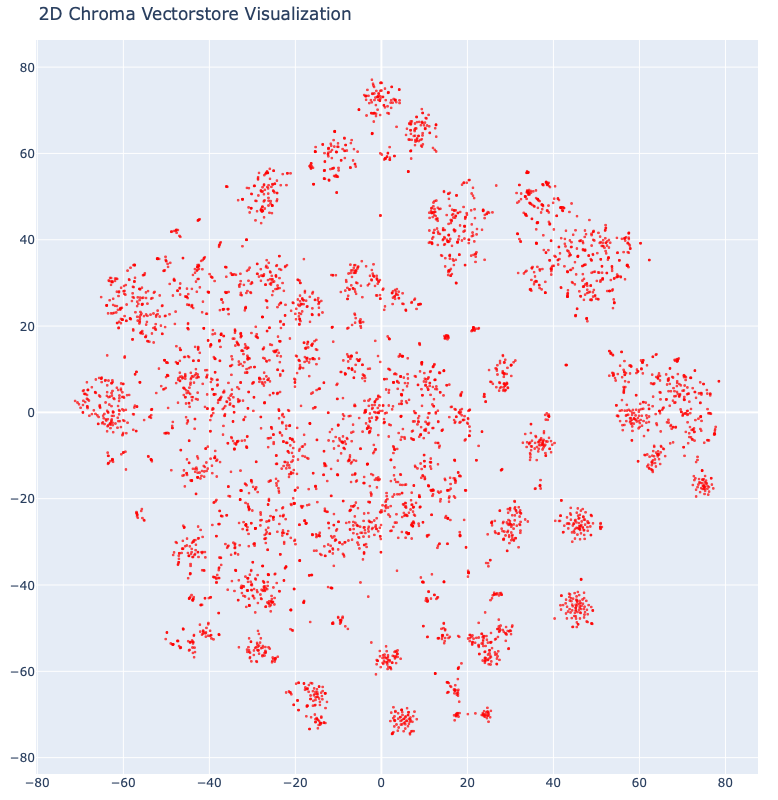

In [30]:
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=3, color=colors, opacity=0.7),
)])

fig.update_layout(
    title='2D Chroma Vectorstore Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y'),
    width=1200,
    height=800,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()